In [1]:
N = 3  # Number of analogues to each query spectrum
TEST_SLICE = -1  # set to -1 for full set

# SSMMCS parameters
SIMILARITY_THESHOLD = 0.2
NORMALIZE_WEIGHTS = True
# Morgan fingerprint parameters
MORGAN_RADIUS = 9
NBITS = 2048
USE_FEATURES = False
FPTYPE = "bv"  # "bv" (bitvector) or "count"

# FMCS parameters
TIMEOUT = 60

In [2]:
import sys
import os

# Get path to the parent directory containing the package
MAIN_FOLDER = os.path.abspath(
    os.path.join(os.getcwd(), "../ms_chemical_space_explorer")
)
DATA_FOLDER = "data"
PROCESSED_DATA_FOLDER = "processed"
FILENAME = "1000_test_spectra.mgf"
FILEPATH = os.path.join(MAIN_FOLDER, DATA_FOLDER, PROCESSED_DATA_FOLDER, FILENAME)
PICKLE = "pickle"

print(f"Adding to path: {MAIN_FOLDER}")
sys.path.append(MAIN_FOLDER)

Adding to path: g:\Dokumente\Studium\MMI\Master-Arbeit\Code\ms_chemical_space_explorer


In [3]:
from rdkit import Chem
from ms_chemical_space_explorer.fragment_extractor import (
    generate_mols_from_spectrum_query,
)
import pickle
from ms_chemical_space_explorer.chemical_space_explorer import start_workflow
from tqdm.notebook import trange, tqdm

# Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)

In [4]:
from typing import Callable
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdFMCS
import pandas as pd

class MCSBenchmarkParams:
    """
    Class to hold parameters for MCS benchmarking.
    """

    def __init__(
        self, method_name: str = "mcs algorithm not defined", file_name: str = FILENAME
    ):
        self.method_name = method_name
        self.file_name = file_name

    def __str__(self) -> str:
        return f"file={self.file_name}"

    def __repr__(self) -> str:
        return self.__str__()

class SSMMCSBenchmarkParams(MCSBenchmarkParams):
    """
    Class to hold parameters for SSMMCS benchmarking.
    """

    def __init__(
        self,
        method_name: str = "SSMMCS",
        file_name: str = FILENAME,
        sim_map_threshold: float = SIMILARITY_THESHOLD,
        normalize_weigths: bool = NORMALIZE_WEIGHTS,
        fingerprint_function: str = "MORGAN",
        min_num_atoms: int = 1,
    ):
        super().__init__(method_name=method_name, file_name=file_name)
        self.fingerprint_function = fingerprint_function.upper()
        self.similarity_threshold = sim_map_threshold
        self.normalize_weights = normalize_weigths
        # MORGAN fingerprint parameters
        self.morgan_radius = MORGAN_RADIUS
        self.nbits = NBITS
        self.use_features = USE_FEATURES
        self.fp_type = FPTYPE
        self.min_num_atoms = min_num_atoms

    def __str__(self) -> str:
        return f"SSMMCS-Benchmark_threshold={self.similarity_threshold}_normalize={self.normalize_weights}_{self.get_fingerprint_params()}_{super().__str__()}"

    def __repr__(self) -> str:
        return self.__str__()

    def get_fingerprint_params(self) -> str:
        param_string = f"fp={self.fingerprint_function}"

        if self.fingerprint_function == "MORGAN":
            return f"{param_string}_r={self.morgan_radius}_type={self.fp_type}_nBits={self.nbits}_useFeatures={self.use_features}"

        return f"{param_string}"

    def get_fingerprint_function(self, mol, atom_id, **kwargs) -> Callable:
        if self.fingerprint_function == "MORGAN":
            return SimilarityMaps.GetMorganFingerprint(
                mol,
                atom_id,
                radius=self.morgan_radius,
                fpType=self.fp_type,
                nBits=self.nbits,
                useFeatures=self.use_features,
                **kwargs,
            )
        elif self.fingerprint_function == "AP":
            return SimilarityMaps.GetAPFingerprint(mol, atom_id, **kwargs)
        elif self.fingerprint_function == "TT":
            return SimilarityMaps.GetTTFingerprint(mol, atom_id, **kwargs)
        elif self.fingerprint_function == "RDK":
            return SimilarityMaps.GetRDKFingerprint(mol, atom_id, **kwargs)
        else:
            raise ValueError(
                f"Unknown fingerprint function: {self.fingerprint_function}"
            )

class FMCSBenchmarkParams(MCSBenchmarkParams):
    """
    Class to hold parameters for FMCS benchmarking.
    """

    def __init__(
        self,
        method_name: str = "FMCS",
        file_name=FILENAME,
        params: rdFMCS.MCSParameters = rdFMCS.MCSParameters(),
    ):
        super().__init__(method_name=method_name, file_name=file_name)
        self.params = params

    def __str__(self) -> str:
        atom_compare_params = self.get_atom_compare_parameters()
        bond_compare_params = self.get_bond_compare_parameters()
        base_params = self.get_base_parameters()
        return f"FMCS-Benchmark_{base_params}_{atom_compare_params}_{bond_compare_params}_{super().__str__()}"

    def __repr__(self) -> str:
        return self.__str__()

    def get_atom_compare_parameters(self) -> str:
        acp = self.params.AtomCompareParameters
        return f"ACCRO={int(acp.CompleteRingsOnly)}_ACRMRO={int(acp.RingMatchesRingOnly)}_MCT={int(acp.MatchChiralTag)}_MFC={int(acp.MatchFormalCharge)}_MI={int(acp.MatchIsotope)}_MV={int(acp.MatchValences)}_MD={acp.MaxDistance}"

    def get_bond_compare_parameters(self) -> str:
        bcp = self.params.BondCompareParameters
        return f"BCCRO={int(bcp.CompleteRingsOnly)}_BCRMRO={int(bcp.RingMatchesRingOnly)}_MFR={int(bcp.MatchFusedRings)}_MFRS={int(bcp.MatchFusedRingsStrict)}_MS={int(bcp.MatchStereo)}"

    def get_base_parameters(self) -> str:
        params = self.params
        return f"AT={int(params.AtomTyper)}_BT={int(params.BondTyper)}_TO={params.Timeout}_SA={int(params.StoreAll)}_MB={int(params.MaximizeBonds)}_TH={params.Threshold}"

class ChemSpaceExplorerBenchmarkParams:
    """
    Class to hold parameters for benchmarking on ChemSpaceExplorer results.
    """

    def __init__(
        self,
        analogues: pd.DataFrame,
        n: int = N,
        test_slice: int = TEST_SLICE,
        method_params: MCSBenchmarkParams = SSMMCSBenchmarkParams(),
    ):
        self.analogues = analogues
        self.n = n
        self.test_slice = test_slice
        self.method_params = method_params

    def __str__(self) -> str:
        if self.test_slice >= 0:
            return f"CSE_n={self.n}_slice={self.test_slice}_{self.method_params}"

        return f"CSE_n={self.n}-{self.method_params}"

    def __repr__(self) -> str:
        return self.__str__()

    def get_method_params(self):
        if self.method_params is SSMMCSBenchmarkParams:
            return SSMMCSBenchmarkParams(
                method_name=self.method_params.method_name,
                file_name=self.method_params.file_name,
                sim_map_threshold=self.method_params.sim_map_threshold,
                normalize_weigths=self.method_params.normalize_weights,
                fingerprint_function=self.method_params.fingerprint_function,
            )
        elif self.method_params is FMCSBenchmarkParams:
            return FMCSBenchmarkParams(
                method_name=self.method_params.method_name,
                file_name=self.method_params.file_name,
                params=self.method_params.params,
            )

    def get_data_slice(self, data):
        if self.test_slice >= 0:
            return data[: self.test_slice]

        return data

# Chemspace Explorer Initialization

In [5]:
from ms_chemical_space_explorer.chemical_space_explorer import spectra_importer

query_spectra = spectra_importer(FILEPATH)

Processing spectra: 100%|██████████| 1000/1000 [00:04<00:00, 243.84it/s]


In [6]:
def analogue_search(n: int = 2):
    file = os.path.join(PICKLE, f"results_n={n}.pkl")
    try:
        with open(file, "rb") as f:
            analogues = pickle.load(f)
            print(f"Loaded analogues from {file}")

    except FileNotFoundError:
        explorer = start_workflow(
            os.path.abspath(
                os.path.join(MAIN_FOLDER, DATA_FOLDER, PROCESSED_DATA_FOLDER)
            )
        )
        analogues = explorer.analogue_search(query_spectra, n=n)

        with open(file, "wb") as f:
            pickle.dump(analogues, f)
        print(f"Analogues saved to {file}")

    return analogues

In [7]:
import pandas as pd

analogues_df = analogue_search(n=N)

Loaded analogues from pickle\results_n=3.pkl


In [8]:
def generate_query_mols():
    file = os.path.join(PICKLE, f"{len(query_spectra)}_query_mols_for_{FILENAME}.pkl")
    query_mols = []
    try:
        with open(file, "rb") as f:
            query_mols = pickle.load(f)
            print(f"Loaded {len(query_mols)} query mols from {file}")

    except FileNotFoundError:
        for query_id, query_spectrum in tqdm(
            enumerate(query_spectra), desc="Generating query mols...", unit="mols"
        ):
            mol = Chem.MolFromSmiles(query_spectrum.metadata["smiles"])
            query_mols.append(mol)

        with open(file, "wb") as f:
            pickle.dump(query_mols, f)
        print(f"{len(query_mols)} query mols saved to {file}.")

    return query_mols


def generate_analogue_mols(dataFrame: pd.DataFrame, n=N):
    file = os.path.join(
        PICKLE,
        f"n={n}_analogue_dataframe_with_{len(query_spectra)*n}_mols_for_{FILENAME}.pkl",
    )
    try:
        with open(file, "rb") as f:
            dataFrame = pickle.load(f)
            print(f"Loaded dataframe with {len(dataFrame)} analogues from {file}")

    except FileNotFoundError:
        for idx, row in tqdm(
            dataFrame.iterrows(),
            desc="Adding mols to analogue dataframe...",
            unit="mols",
        ):
            mol = Chem.MolFromSmiles(row["smiles"])
            dataFrame.loc[idx, "mol"] = mol

        with open(file, "wb") as f:
            pickle.dump(dataFrame, f)
        print(f"Dataframe with {len(dataFrame)} analogue mols saved to {file}.")

    return dataFrame

In [9]:
if TEST_SLICE > 0:
    query_mols = generate_query_mols()[:TEST_SLICE]
else:
    query_mols = generate_query_mols()

analogues_df = generate_analogue_mols(analogues_df)

Loaded 603 query mols from pickle\603_query_mols_for_1000_test_spectra.mgf.pkl
Loaded dataframe with 1806 analogues from pickle\n=3_analogue_dataframe_with_1809_mols_for_1000_test_spectra.mgf.pkl


In [10]:
analogues_df

,smiles,predicted distance,mean distance,std distance,isf,candidate mean similarity,candidate std similarity,precursor-mz-diff,visual_x,visual_y,inchikey,query_spectrum_id,ionmode,mol
1482,CCCCC\C=C/C\C=C/CCCCCCCC(=O)OCC(COP(O)(=O)OC1C...,0.037059,0.039915,0.005182,0.966980,0.951327,0.039300,-4.033600,10.855725,2.893498,IDBHHLONPONREV,176,negative,<rdkit.Chem.rdchem.Mol object at 0x000001C095B...
1483,CCCCCCCCCCCCCCCCC(=O)OCC(COP(O)(=O)OC1C(O)C(O)...,0.039129,0.039915,0.005182,0.966980,0.951327,0.039300,-14.021600,6.573919,3.105054,NHCUHDJVBAQLLF,176,negative,<rdkit.Chem.rdchem.Mol object at 0x000001C095B...
1484,CCCCCCCCCCCCCCCCCC(=O)OCC(COP(O)(=O)OC1C(O)C(O...,0.040339,0.039915,0.005182,0.966980,0.951327,0.039300,2.010600,14.638113,-5.208595,GGSSNEAFVQRIHU,176,negative,<rdkit.Chem.rdchem.Mol object at 0x000001C095B...
1691,CCCCC/C=C\C/C=C\C/C=C\CCCCCCC(=O)O[C@H](COC(=O...,0.042183,0.036931,0.004866,0.964284,0.947459,0.039397,19.968000,8.401516,1.257386,DYTUHXQCMCKAHL,245,negative,<rdkit.Chem.rdchem.Mol object at 0x000001C095C...
1690,CCCCC\C=C/C\C=C/CCCCCCCC(=O)OCC(COP(O)(=O)OC1C...,0.039124,0.036931,0.004866,0.964284,0.947459,0.039397,-6.041800,12.741820,0.653669,PJGBJPJEYMOHKG,245,negative,<rdkit.Chem.rdchem.Mol object at 0x000001C095B...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,Cn1cncc1C[C@@H](C(=O)O)N,0.215882,0.190069,0.046234,0.112656,0.035263,0.170949,0.010830,8.573842,1.309396,JDHILDINMRGULE,355,positive,<rdkit.Chem.rdchem.Mol object at 0x000001C095C...
62,N1C=NC2=C1C=NC=N2,0.114903,0.127105,0.011707,0.110706,0.065361,0.230543,-46.030500,11.015861,4.740924,KDCGOANMDULRCW,304,positive,<rdkit.Chem.rdchem.Mol object at 0x000001C095D...
840,NC(N)=O,0.104779,0.161976,0.032626,0.106825,0.010000,0.099499,-59.025321,14.382889,4.222836,XSQUKJJJFZCRTK,564,positive,<rdkit.Chem.rdchem.Mol object at 0x000001C095D...
892,CN1C=NC=C1,0.322333,0.310428,0.011798,0.099405,0.020233,0.139976,-47.025875,16.075138,0.348935,MCTWTZJPVLRJOU,582,positive,<rdkit.Chem.rdchem.Mol object at 0x000001C095D...


In [11]:
# sanity check
if TEST_SLICE > 0:
    assert len(query_mols[:TEST_SLICE]) == len(query_spectra[:TEST_SLICE])
else:
    assert len(query_mols) == len(query_spectra)
assert analogues_df["query_spectrum_id"].nunique() == len(query_spectra)
assert len(analogues_df) >= len(query_spectra)
assert len(analogues_df) <= len(query_spectra) * N

len(query_spectra) * N

1809

In [12]:
def chemspace_explorer_benchmark(
    query_mols, params: ChemSpaceExplorerBenchmarkParams, method: Callable
):
    filename = f"{len(query_mols)}_results_for_{params}.csv"
    # Sanitize the whole filename again just to be safe
    filename = sanitize_filename(filename)
    file = os.path.join(DATA_FOLDER, filename)

    if os.path.exists(file):
        df = pd.read_csv(file)
        print(
            f"Loaded {len(df)} {params.method_params.method_name} results from {file}."
        )
    else:
        try:
            print(f"Running {params.method_params.method_name}...")
            df = method(query_mols, params.analogues, params.method_params)

            if len(df) == 0:
                print(f"No results for {params.method_params}.")
                return None

            # Save CSV once after all processing is complete
            os.makedirs(os.path.dirname(file), exist_ok=True)
            df.to_csv(file, index=False)
            print(
                f"Saved {len(df)} {params.method_params.method_name} results to {file}."
            )
        except Exception as e:
            print(f"Error during {params.method_params.method_name} processing: {e}")
            return None

    return df

def sanitize_filename(filename):
    """Replace invalid filename characters with underscores."""
    # Characters not allowed in Windows filenames
    invalid_chars = r'<>:"/\|?*(),'
    for char in invalid_chars:
        filename = filename.replace(char, "___")
    return filename

In [13]:
def get_query_analogues(query_id: int, analogues_df: pd.DataFrame) -> list:
    return analogues_df[analogues_df["query_spectrum_id"] == query_id]["mol"].tolist()

# FMCS

In [14]:
import time

def benchmark_fmcs(query_mols, analogues:pd.DataFrame, fmcs_params: FMCSBenchmarkParams):
    fmcs_df = pd.DataFrame()

    for query_id, query_mol in tqdm(
        enumerate(query_mols), total=len(query_mols), desc="Benchmarking FMCS"
    ):
        try:
            query_analogues = get_query_analogues(query_id, analogues)
            if len(query_analogues) < 2:
                print(
                    f"Skipping query {query_id} due to insufficient number of analogues!"
                )
                continue

            start_time = time.time()
            fmcs = rdFMCS.FindMCS(query_analogues, fmcs_params.params)
            elapsed_time = time.time() - start_time

            matched = False
            query_match = None
            smartsString = None
            degenerate_smarts = None

            if fmcs_params.params.StoreAll:
                print(
                    f"Found {len(fmcs.degenerateSmartsQueryMolDict)} degenerate MCSes for query {query_id}."
                )
                degenerate_smarts = []
                for smarts, mcs in fmcs.degenerateSmartsQueryMolDict.items():
                    # only update match result, if we haven't found a match yet
                    if not matched:
                        degenerate_mcs_match = query_mol.GetSubstructMatch(mcs)
                        degenerate_mcs_matched = len(degenerate_mcs_match) > 0

                        if degenerate_mcs_matched:
                            query_match = degenerate_mcs_match
                            smartsString = smarts
                            matched = True

                    # only store additional smarts to the matched smarts
                    if smartsString != smarts:
                        degenerate_smarts.append(smarts)

            else:
                query_match = query_mol.GetSubstructMatch(fmcs.queryMol)
                matched = len(query_match) > 0
                smartsString = fmcs.smartsString

            aborted = fmcs.canceled

            # Save data as a row
            new_row = {
                "query_id": query_id,
                "mcs_matched_query": matched,
                "failed": aborted,
                "time": elapsed_time,
                "mcs_size": fmcs.numAtoms,
                "mcs_smarts": smartsString,
                "query_match": query_match if matched else None,
                "degenerate_smarts": degenerate_smarts,
            }
            fmcs_df = pd.concat([fmcs_df, pd.DataFrame([new_row])], ignore_index=True)
        except Exception as e:
            print(f"Error processing query {query_id}: {e}")
            continue

    return fmcs_df

In [15]:
rdfmcs_params = rdFMCS.MCSParameters()
rdfmcs_params.AtomTyper = rdFMCS.AtomCompare.CompareElements
rdfmcs_params.BondTyper = rdFMCS.BondCompare.CompareOrderExact
rdfmcs_params.AtomCompareParameters.RingMatchesRingOnly = True
rdfmcs_params.Timeout = TIMEOUT

fmcs_params = FMCSBenchmarkParams(params=rdfmcs_params)
cse_fmcs_params = ChemSpaceExplorerBenchmarkParams(analogues=analogues_df, method_params=fmcs_params)

# Create sanitized parameter string first
fmcs_df = chemspace_explorer_benchmark(
    query_mols, cse_fmcs_params, method=benchmark_fmcs
)

Loaded 602 FMCS results from data\603_results_for_CSE_n=3-FMCS-Benchmark_AT=1_BT=2_TO=60_SA=0_MB=1_TH=1.0_ACCRO=0_ACRMRO=1_MCT=0_MFC=0_MI=0_MV=0_MD=-1.0_BCCRO=0_BCRMRO=0_MFR=0_MFRS=0_MS=0_file=1000_test_spectra.mgf.csv.


In [16]:
fmcs_df

,query_id,mcs_matched_query,failed,time,mcs_size,mcs_smarts,query_match,degenerate_smarts
0,0,True,False,0.008003,42,[#6&!R]-[#6&!R]-[#6&!R]-[#6&!R]-[#6&!R]-[#6&!R...,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",NaN
1,1,True,False,0.011999,10,[#8&!R]-[#6]1-[#6](-[#8&!R])-[#8]-[#6]-[#6](-[...,"(7, 8, 9, 30, 10, 18, 25, 31, 19, 26)",NaN
2,2,True,False,0.711001,22,[#8&!R]-[#6]1-[#6](-[#8&!R])-[#6](-[#8&!R])-[#...,"(8, 7, 5, 9, 6, 4, 15, 10, 3, 16, 17, 18, 19, ...",NaN
3,3,True,False,0.002001,20,[#6]1-[#6]2:[#6](-[#8&!R]):[#6]:[#6](:[#6]:[#6...,"(2, 3, 1, 4, 10, 12, 0, 5, 6, 9, 11, 13, 7, 14...",NaN
4,4,False,False,0.015997,15,[#6]1-[#6]-[#6]-[#6]-[#6]2-[#6]-1(-[#6]-[#6]-[...,NaN,NaN
...,...,...,...,...,...,...,...,...
597,598,False,False,0.180996,15,[#8&!R]=[#6]1:[#6]:[#6]:[#8]:[#6]2:[#6]:1:[#6]...,NaN,NaN
598,599,False,False,0.811000,19,[#8&!R]=[#6]1:[#6]:[#6](:[#8]:[#6]2:[#6]:1:[#6...,NaN,NaN
599,600,False,False,0.103999,21,[#8&!R]-[#6]1:[#6]2:[#6](:[#8]:[#6]3:[#6](:[#6...,NaN,NaN
600,601,False,False,0.000000,19,[#6]1-[#6]-[#7](-[#6]-[#6]-[#7]-1)-[#6&!R](-[#...,NaN,NaN


# SSMMCS

In [17]:
from rdkit.Chem.Draw import SimilarityMaps

def get_stacked_sim_map_fragments_and_weights(
    mols: list[Chem.Mol],
    fp_function: Callable = SimilarityMaps.GetMorganFingerprint,
    similarity_threshold: float = SIMILARITY_THESHOLD,
    normalize_stacked_weights: bool = NORMALIZE_WEIGHTS,
) -> tuple[list[Chem.Mol], list[list[float]]]:

    stacked_weights = []
    all_analogue_fragments = []

    for ref_mol in mols:
        ref_mol_smiles = Chem.MolToSmiles(ref_mol)
        ref_mol_stacked_weights = [0] * ref_mol.GetNumAtoms()
        for probe_mol in mols:
            probe_mol_smiles = Chem.MolToSmiles(probe_mol)
            # Skip if comparing molecule to itself
            if probe_mol_smiles == ref_mol_smiles:
                continue

            # extract similarity weights for the reference molecule
            sim_weights = SimilarityMaps.GetAtomicWeightsForFingerprint(
                probe_mol, ref_mol, fp_function
            )
            sim_weights, _ = SimilarityMaps.GetStandardizedWeights(sim_weights)

            assert (
                len(sim_weights) == ref_mol.GetNumAtoms()
            ), "Length of sim_weights does not match number of atoms in reference molecule."
            # stack the weights
            ref_mol_stacked_weights = [
                ref_mol_stacked_weights[i] + sim_weights[i]
                for i in range(ref_mol.GetNumAtoms())
            ]

        if normalize_stacked_weights:
            ref_mol_stacked_weights, _ = SimilarityMaps.GetStandardizedWeights(
                ref_mol_stacked_weights
            )

        stacked_weights.append(ref_mol_stacked_weights)

        # Extract fragments from the reference molecule using the similarity weights
        analogue_fragments = extract_sim_map_fragments_from_mol(
            ref_mol, ref_mol_stacked_weights, similarity_threshold
        )
        all_analogue_fragments.extend(analogue_fragments)

    return all_analogue_fragments, stacked_weights

def find_SSMMCS_and_SSMMSS(
    mols: list[Chem.Mol], substruct_candidates: list[Chem.Mol], min_num_atoms: int = 1
) -> tuple[Chem.Mol | None, Chem.Mol | None]:

    common_substructs = []
    unique_smiles = set()
    mcs_id = -1
    mcs_size = 0
    mss = None
    mss_size = 0

    for substruct in substruct_candidates:
        num_Atoms = substruct.GetNumAtoms()

        # skip substructs below atom threshold
        if num_Atoms < min_num_atoms:
            continue

        # skip duplicates
        smiles = Chem.MolToSmiles(substruct)
        if smiles in unique_smiles:
            continue
        unique_smiles.add(smiles)

        # find the maximum stacked substructure (MSS)
        if num_Atoms > mss_size:
            mss = substruct
            mss_size = num_Atoms

        # find the maximum common substructure (MCS)
        is_common = True
        for analogue in mols:
            if len(analogue.GetSubstructMatch(substruct)) <= 0:
                is_common = False
                break

        if not is_common:
            continue
        common_substructs.append(substruct)

        if num_Atoms > mcs_size:
            mcs_id = len(common_substructs) - 1
            mcs_size = num_Atoms

        # if MSS and MCS are the same size, update MSS to MCS
        if num_Atoms == mss_size:
            mss = common_substructs[mcs_id]

    if mcs_id < 0:
        mcs = None
    else:
        mcs = common_substructs[mcs_id]

    return mcs, mss

def extract_sim_map_fragments_from_mol(
    mol: Chem.Mol, similarity_weights: list[float], similarity_threshold: float
) -> list[Chem.Mol]:

    visited = set()
    fragment_mols = []

    # Iterate through all atoms to find connected_atoms
    for atom in mol.GetAtoms():
        atom_idx = atom.GetIdx()
        if (
            atom_idx not in visited
            and similarity_weights[atom_idx] >= similarity_threshold
        ):
            connected_atoms = find_connected_atoms_recursive(
                atom_idx, visited, mol, similarity_weights, similarity_threshold
            )
            if connected_atoms:
                # Create a new molecule for this connected_atoms
                fragment = Chem.RWMol(mol)

                # Create a map of atoms to remove (those not in connected_atoms)
                atoms_to_remove = set(range(mol.GetNumAtoms())) - connected_atoms

                # Remove atoms not in connected_atoms (remove in reverse order to preserve indices)
                for remove_idx in sorted(atoms_to_remove, reverse=True):
                    fragment.RemoveAtom(remove_idx)

                # Convert to regular molecule and add to list
                fragment_mols.append(fragment.GetMol())

    return fragment_mols

def find_connected_atoms_recursive(
    atom_idx: int,
    visited: set[int],
    mol: Chem.Mol,
    similarity_weights: list[float],
    similarity_threshold: float,
) -> set[int]:
    if atom_idx in visited or similarity_weights[atom_idx] < similarity_threshold:
        return set()

    atoms = {atom_idx}
    visited.add(atom_idx)

    # Get current atom object
    atom = mol.GetAtomWithIdx(atom_idx)

    # Iterate through bonds to neighboring atoms
    for bond in atom.GetBonds():
        # Get the neighboring atom's index
        neighbor_idx = (
            bond.GetBeginAtomIdx()
            if bond.GetEndAtomIdx() == atom_idx
            else bond.GetEndAtomIdx()
        )

        if similarity_weights[neighbor_idx] >= similarity_threshold:
            atoms.update(
                find_connected_atoms_recursive(
                    neighbor_idx, visited, mol, similarity_weights, similarity_threshold
                )
            )

    return atoms

def score_stacked_weights_against_query(query: Chem.Mol, analogues: list[Chem.Mol], stacked_weights: list[list[float]], fp_fuction: Callable, normalize_weights: bool
                                        )-> tuple[float, list[float]]: 
    analogue_weight_differences = []
    for i, analogue in enumerate(analogues):
        assert (len(stacked_weights[i]) == analogue.GetNumAtoms()), f"Length of stacked_weights {i} does not match number of atoms in analogue {i}."
        
        query_weights = SimilarityMaps.GetAtomicWeightsForFingerprint(query, analogue, fp_fuction)
        if(normalize_weights):
            query_weights, _ = SimilarityMaps.GetStandardizedWeights(query_weights)

        atom_weight_differences = [stacked_weights[i][j] - query_weights[j] for j in range(len(stacked_weights[i]))] # calculate a list of weight differences for each atom
        analogue_weight_differences.append(sum(atom_weight_differences) / len(atom_weight_differences)) # average of all atom weight differences
    
    query_weight_difference = sum(analogue_weight_differences) / len(analogue_weight_differences)
    
    return query_weight_difference, analogue_weight_differences

In [18]:
import time

def benchmark_ssmmcs(query_mols, analogues: pd.DataFrame, ssmmcs_params: SSMMCSBenchmarkParams):
    ssmmcs_df = pd.DataFrame()

    for query_id, query_mol in tqdm(
        enumerate(query_mols), total=len(query_mols), desc="Benchmarking SSMMCS"
    ):
        try:
            query_analogues = get_query_analogues(query_id, analogues)
            if len(query_analogues) < 2:
                print(
                    f"Skipping query {query_id} due to insufficient number of analogues!"
                )
                continue
            
            # calculate ssmmcs and ssmss
            start_time = time.time()
            all_analogue_fragments, stacked_weigths = get_stacked_sim_map_fragments_and_weights(mols=query_analogues,
                                                                                                fp_function=ssmmcs_params.get_fingerprint_function,
                                                                                                similarity_threshold=ssmmcs_params.similarity_threshold,
                                                                                                normalize_stacked_weights=ssmmcs_params.normalize_weights,
                                                                                                )
            mcs, mss = find_SSMMCS_and_SSMMSS(query_analogues, all_analogue_fragments, min_num_atoms=ssmmcs_params.min_num_atoms)
            elapsed_time = time.time() - start_time
            
            # gather data
            if mcs is None:
                mcs_matched_query = False
                mcs_size = 0
                query_match_mcs = None
                mcs_smarts = ""
            else:
                query_match_mcs = query_mol.GetSubstructMatch(mcs)
                mcs_matched_query = len(query_match_mcs) > 0
                mcs_size = mcs.GetNumAtoms()
                mcs_smarts = Chem.MolToSmarts(mcs)

            if mss is None:
                mss_matched_query = False
                mss_size = 0
                query_match_mss = None
                mss_smarts = ""
            else:
                query_match_mss = query_mol.GetSubstructMatch(mss)
                mss_matched_query = len(query_match_mss) > 0
                mss_size = mss.GetNumAtoms()
                mss_smarts = Chem.MolToSmarts(mss)
            
            # check the quality of the stacked similarity weights against the actual query similarity weights
            query_weight_diff, analogue_weight_diffs = score_stacked_weights_against_query(
                query_mol, query_analogues, stacked_weigths, ssmmcs_params.get_fingerprint_function, ssmmcs_params.normalize_weights)

            # Save data as a row
            new_row = {
                "query_id": query_id,
                "mcs_matched_query": mcs_matched_query, # boolean
                "mss_matched_query": mss_matched_query,
                "failed": not mcs_matched_query and not mss_matched_query,
                "time": elapsed_time,
                "mcs_size": mcs_size,
                "mcs_smarts": mcs_smarts,
                "mss_size": mss_size,
                "mss_smarts": mss_smarts,
                "query_match_mcs": query_match_mcs,     # list of query atom indices
                "query_match_mss": query_match_mss,
                "query_weight_diff": query_weight_diff, # average of all analogue weight differences
                "analogue_weight_diffs": analogue_weight_diffs, # list of average weight differences for each analogue
            }
            ssmmcs_df = pd.concat(
                [ssmmcs_df, pd.DataFrame([new_row])], ignore_index=True
            )
        except Exception as e:
            print(f"Error processing query {query_id}: {e}")
            continue

    return ssmmcs_df

In [19]:
ssmmcs_params = SSMMCSBenchmarkParams(
    method_name="SSMMCS",
    file_name=FILENAME,
    sim_map_threshold=SIMILARITY_THESHOLD,
    normalize_weigths=NORMALIZE_WEIGHTS,
    fingerprint_function="morgan",
)

cse_ssmmcs_params = ChemSpaceExplorerBenchmarkParams(analogues=analogues_df, method_params=ssmmcs_params)

ssmmcs_df = chemspace_explorer_benchmark(
    query_mols, params=cse_ssmmcs_params, method=benchmark_ssmmcs
)

ssmmcs_df

Loaded 602 SSMMCS results from data\603_results_for_CSE_n=3-SSMMCS-Benchmark_threshold=0.2_normalize=True_fp=MORGAN_r=9_type=bv_nBits=2048_useFeatures=False_file=1000_test_spectra.mgf.csv.


,query_id,mcs_matched_query,mss_matched_query,failed,time,mcs_size,mcs_smarts,mss_size,mss_smarts,query_match_mcs,query_match_mss,query_weight_diff,analogue_weight_diffs
0,0,True,False,False,0.173998,41,[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[...,45,[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[...,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",(),0.041697,"[0.06427971621750188, 0.06982235984502559, -0...."
1,1,True,True,False,0.113002,11,[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[...,32,[#6]-[#6]-[#6](=[#8])-[#8]-[#6@@H]1-[#6@H](-[#...,"(32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43)","(3, 4, 5, 6, 7, 8, 9, 10, 11, 18, 19, 25, 26, ...",-0.038958,"[0.02155444855219323, -0.14796925983435172, 0...."
2,2,True,True,False,0.072002,5,[#6]-[#6]-[#8]-[#6]:[#6],18,[#6]-[#6]1:[#6]:[#6](:[#6](:[#6]:[#8]:1):[#6]:...,"(4, 16, 17, 18, 19)","(23, 22, 24, 25, 27, 20, 18, 17, 16, 4, 3, 1, ...",0.080303,"[0.3625963182942486, -0.21892903867352687, 0.0..."
3,3,True,True,False,0.050002,19,[#6]1:[#6](-[#8]):[#6]:[#6](-[#8]):[#6]:[#6]:1...,19,[#6]1:[#6](-[#8]):[#6]:[#6](-[#8]):[#6]:[#6]:1...,"(3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","(3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...",0.067356,"[0.03085859569324029, -0.022096196644254294, 0..."
4,4,False,False,True,0.027999,10,[#6]1-[#6](-[#6])(-[#6](=[#8])-[#8])-[#6]-[#6]...,10,[#6]1-[#6](-[#6])(-[#6](=[#8])-[#8])-[#6]-[#6]...,(),(),0.442022,"[0.5275791711548014, 0.3097460137087136, 0.488..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,598,False,False,True,0.051999,3,[#6](:[#6])-[#6@@H],18,[#6]1:[#6](:[#6](-[#8]):[#6]):[#6](:[#6]):[#8]...,(),(),-0.048824,"[0.4006088317992556, 0.12315490354495255, -0.6..."
598,599,False,False,True,0.079001,11,[#6]-[#8]-[#6]1-[#8]-[#6]-[#6](-[#8])-[#6](-[#...,11,[#6]-[#8]-[#6]1-[#8]-[#6]-[#6](-[#8])-[#6](-[#...,(),(),-0.114271,"[-0.21489608421891088, -0.3230708537460308, 0...."
599,600,True,False,False,0.034000,1,[#6],16,[#6]1:[#6]2:[#6](:[#8]:[#6]:[#6](:[#6]):[#6]:2...,"(1,)",(),0.191418,"[0.470657926835426, -0.06831207713561661, 0.17..."
600,601,False,False,True,0.021998,19,[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#6]1...,19,[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#6]1...,(),(),0.354039,"[0.43016793217484867, 0.3197215228177847, 0.31..."


In [ ]:
n2=6
analogues_df2 = analogue_search(n=n2)
analogues_df2 = generate_analogue_mols(analogues_df2, n=n2)

cse_ssmmcs_params2 = ChemSpaceExplorerBenchmarkParams(analogues=analogues_df2, n=n2, method_params=ssmmcs_params)

ssmmcs_df2 = chemspace_explorer_benchmark(
    query_mols, params=cse_ssmmcs_params2, method=benchmark_ssmmcs
)

ssmmcs_df2

Loaded analogues from pickle\results_n=6.pkl
Loaded dataframe with 3597 analogues from pickle\n=6_analogue_dataframe_with_3618_mols_for_1000_test_spectra.mgf.pkl
Running SSMMCS...


Benchmarking SSMMCS:   0%|          | 0/603 [00:00<?, ?it/s]

Skipping query 564 due to insufficient number of analogues!
Saved 602 SSMMCS results to data\603_results_for_CSE_n=6-SSMMCS-Benchmark_threshold=0.2_normalize=True_fp=MORGAN_r=9_type=bv_nBits=2048_useFeatures=False_file=1000_test_spectra.mgf.csv.


,query_id,mcs_matched_query,mss_matched_query,failed,time,mcs_size,mcs_smarts,mss_size,mss_smarts,query_match_mcs,query_match_mss,query_weight_diff,analogue_weight_diffs
0,0,True,False,False,0.735000,9,[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6],46,[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[...,"(0, 1, 2, 3, 4, 5, 6, 7, 8)",(),0.011226,"[0.05425968321956817, 0.062442346964605114, -0..."
1,1,True,True,False,0.461003,8,[#6](-[#8])-[#6](-[#6](-[#6]-[#8])-[#8])-[#8],23,[#6]-[#6]-[#6](=[#8])-[#8]-[#6@@H]1-[#6@H](-[#...,"(8, 7, 19, 18, 25, 26, 30, 31)","(3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18, 19, ...",0.009433,"[-0.19050965550532845, -0.10747710453284086, 0..."
2,2,True,True,False,0.348999,3,[#6]-[#8]-[#6],20,[#8](-[#6@@H]-[#6@H](-[#8]-[#6]1:[#6]:[#6]:[#6...,"(1, 3, 4)","(4, 3, 1, 2, 0, 16, 17, 18, 19, 20, 22, 23, 24...",0.010526,"[0.3290432008162846, -0.20209108086292332, 0.0..."
3,3,True,True,False,0.211000,2,[#6]:[#6],19,[#6]1:[#6](-[#8]):[#6]:[#6](-[#8]):[#6]:[#6]:1...,"(3, 4)","(3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...",0.146905,"[-0.02792994393140232, -0.06223396289616593, 0..."
4,4,False,False,True,0.142998,4,[#6]-[#6]-[#6]-[#6],9,[#6]-[#6](-[#6])(-[#6](=[#8])-[#8])-[#6]-[#6]-...,(),(),0.433617,"[0.5475431057049285, 0.23327767036472158, 0.56..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,598,True,False,False,0.245001,5,[#6]:[#6]:[#6]:[#6]:[#6],18,[#6]1:[#6]2:[#6](-[#8]):[#6]:[#6]:[#6]:[#6]:2:...,"(2, 3, 4, 29, 8)",(),-0.205260,"[0.37141707800239826, -0.11777545515789786, -0..."
598,599,False,False,True,0.373000,9,[#6]1-[#8]-[#6]-[#6](-[#8])-[#6](-[#8])-[#6]-1...,22,[#8]=[#6]1:[#6]:[#6](:[#8]:[#6](:[#6]:[#6]-[#8...,(),(),0.035520,"[-0.27321239755431687, -0.22827671045539655, 0..."
599,600,False,False,True,0.174998,5,[#6]:[#6](:[#6]):[#6]=[#8],12,[#6](:[#6]:[#6]-[#17]):[#6](:[#6]1:[#6]:[#6]:[...,(),(),-0.007069,"[0.25330743494362873, -0.10350298542314885, 0...."
600,601,True,True,False,0.116999,6,[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1,13,[#6](-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#6]1:...,"(7, 8, 9, 10, 11, 12)","(6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18)",0.134603,"[0.249396328411239, 0.16482290055978316, 0.188..."


In [39]:
ssmmcs_df3.iloc[0].analogue_weight_diffs

[0.04862331493013793,
 0.061771469590744636,
 -0.08929068759766995,
 0.13598686110442607,
 -0.09060377596267653,
 0.055609057949712354,
 0.017069225818372145,
 -0.01105749208156548]

In [ ]:
n3=8
analogues_df3 = analogue_search(n=n3)
analogues_df3 = generate_analogue_mols(analogues_df3, n=n3)

cse_ssmmcs_params3 = ChemSpaceExplorerBenchmarkParams(analogues=analogues_df3, n=n3, method_params=ssmmcs_params)

ssmmcs_df3 = chemspace_explorer_benchmark(
    query_mols, params=cse_ssmmcs_params3, method=benchmark_ssmmcs
)

ssmmcs_df3

Initialize ChemExplorer


d:\Programmierung\anaconda3\envs\chemspace\Lib\site-packages\ms2deepscore\models\load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_settings = torch.load(

Analogues saved to pickle\results_n=8.pkl


Adding mols to analogue dataframe...: 0mols [00:00, ?mols/s]

Dataframe with 4773 analogue mols saved to pickle\n=8_analogue_dataframe_with_4824_mols_for_1000_test_spectra.mgf.pkl.
Running SSMMCS...


Benchmarking SSMMCS:   0%|          | 0/603 [00:00<?, ?it/s]

Skipping query 564 due to insufficient number of analogues!
Saved 602 SSMMCS results to data\603_results_for_CSE_n=8-SSMMCS-Benchmark_threshold=0.2_normalize=True_fp=MORGAN_r=9_type=bv_nBits=2048_useFeatures=False_file=1000_test_spectra.mgf.csv.


,query_id,mcs_matched_query,mss_matched_query,failed,time,mcs_size,mcs_smarts,mss_size,mss_smarts,query_match_mcs,query_match_mss,query_weight_diff,analogue_weight_diffs
0,0,True,False,False,1.588998,5,[#6]-[#6]-[#6]-[#6]-[#6],46,[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[...,"(0, 1, 2, 3, 4)",(),0.016013,"[0.04862331493013793, 0.061771469590744636, -0..."
1,1,True,False,False,0.876002,5,[#6]-[#6]-[#6]-[#6]-[#6],36,[#6]-[#6](=[#8])-[#8]-[#6@@H]1-[#6]-[#6@@]2(-[...,"(0, 1, 2, 3, 4)",(),0.022989,"[-0.15901088794964605, -0.1456776975823047, 0...."
2,2,True,True,False,0.835002,5,[#6]:[#6]:[#6]:[#6]:[#6],24,[#6]-[#6]1:[#6]:[#6](:[#6]2:[#6](:[#6]:[#6](-[...,"(18, 19, 20, 27, 25)","(23, 22, 24, 25, 27, 20, 19, 18, 17, 16, 4, 10...",0.109790,"[0.44211309934207393, -0.1193743510436255, 0.1..."
3,3,True,True,False,0.404999,4,[#6]:[#6](:[#6])-[#8],19,[#6]1:[#6](-[#8]):[#6]:[#6](-[#8]):[#6]:[#6]:1...,"(3, 6, 4, 5)","(3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...",0.095936,"[0.06707228714434614, -0.024104130056578462, 0..."
4,4,False,False,True,0.251998,2,[#6]-[#6],6,[#6](-[#6](=[#8])-[#8])-[#6]-[#6],(),(),0.277492,"[0.3786932525420328, 0.027002785160822572, 0.4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,598,True,False,False,0.526002,1,[#6],23,[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[...,"(0,)",(),-0.174993,"[0.3421003964265769, -0.18707265984541113, -0...."
598,599,True,False,False,0.757999,5,[#6](:[#6]):[#6]:[#6]:[#6],28,[#8]=[#6]1:[#6]:[#6](:[#8]:[#6]2:[#6]:[#6](-[#...,"(2, 3, 5, 6, 7)",(),0.205932,"[-0.17103775049074077, -0.15244262720344517, 0..."
599,600,True,False,False,0.380999,2,[#6]:[#6],12,[#6]:[#6]:[#6]:[#6](-[#8]-[#6]):[#6](-[#8]-[#6...,"(1, 2)",(),0.012109,"[0.04114418472887762, -0.1270548099047763, 0.1..."
600,601,True,False,False,0.218003,6,[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1,9,[#6]:[#6]:[#6]:[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1,"(7, 8, 9, 10, 11, 12)",(),0.082866,"[0.2004972076458264, 0.12722054512587494, 0.15..."


# Benchmark results

### time

In [23]:
fmcs_df["time"].sum(), ssmmcs_df["time"].sum()

(2345.551613807678, 35.95797109603879)

In [24]:
fmcs_df["time"].mean(), ssmmcs_df["time"].mean()

(3.896265139215412, 0.05973084899674218)

### MCS Size

In [25]:
fmcs_df.mcs_size.mean(), ssmmcs_df.mcs_size.mean(), fmcs_df.mcs_size.std(), ssmmcs_df.mcs_size.std()

(16.767441860465116, 10.232558139534884, 11.169354456241413, 8.308470695137299)

In [26]:
ssmmcs_df.mss_size.mean(), ssmmcs_df.mss_size.std()

(17.86046511627907, 12.956620255126454)

In [27]:
# show the mcs size difference between ssmmcs and fmcs
mask = (ssmmcs_df["mcs_matched_query"] == True) & (fmcs_df["mcs_matched_query"] == True)
botch_mathed = ssmmcs_df.loc[mask, "mcs_size"] - fmcs_df.loc[mask, "mcs_size"]
botch_mathed.mean(), botch_mathed.std(), botch_mathed.min(), botch_mathed.max()

(-4.032967032967033, 5.1570914528492535, -30, 6)

In [28]:
ssmmcs_df["mcs_size"].unique()

array([41, 11,  5, 19, 10,  8, 20,  6,  9,  2, 22,  3,  7,  4, 14, 13, 16,
       26, 15,  1, 32, 25, 12, 17, 23, 27, 21, 33, 29,  0, 40, 39, 18, 36,
       43, 24, 44, 37, 35, 28, 31, 34, 42, 30], dtype=int64)

### MCS found

In [29]:
fmcs_df.mcs_matched_query.sum() / len(fmcs_df), ssmmcs_df.mcs_matched_query.sum() / len(ssmmcs_df)

(0.3222591362126246, 0.5365448504983389)

In [30]:
ssmmcs_df.mcs_matched_query.sum(), ssmmcs_df.mss_matched_query.sum()

(323, 151)

In [31]:
# show all fmcs queries where ssmmcs failed
fmcs_df[(fmcs_df["mcs_matched_query"] == True) & (ssmmcs_df["mcs_matched_query"] == False)]

,query_id,mcs_matched_query,failed,time,mcs_size,mcs_smarts,query_match,degenerate_smarts
12,12,True,False,0.001001,8,[#6&!R]-[#6&!R]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1,"(7, 6, 3, 2, 4, 1, 5, 0)",NaN
239,239,True,False,0.002001,8,[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6&!R]-[#6...,"(8, 7, 9, 6, 10, 5, 1, 2)",NaN
241,241,True,False,0.049000,17,[#8&!R]=[#6]1-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2...,"(0, 1, 2, 14, 3, 10, 13, 15, 4, 8, 11, 20, 16,...",NaN
343,343,True,True,60.711000,30,[#6&R](-[#6&R]-[#6&R]-[#6&R](-[#6&R]-[#6&R])-[...,"(26, 27, 25, 28, 23, 18, 24, 22, 17, 19, 16, 1...",NaN
348,348,True,False,0.008000,14,[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6&R]:[#6&...,"(23, 22, 26, 21, 27, 20, 19, 18, 4, 3, 9, 7, 6...",NaN
389,389,True,False,0.001001,1,[#6&!R],"(0,)",NaN
401,401,True,False,0.019000,45,[#6&!R]-[#6&!R]-[#6&!R](-[#6&!R])-[#6&!R](-[#8...,"(16, 15, 13, 14, 12, 11, 17, 9, 18, 19, 4, 10,...",NaN
417,417,True,False,0.000000,6,[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1,"(4, 5, 10, 6, 8, 7)",NaN
487,487,True,False,0.001999,6,[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1,"(9, 10, 14, 11, 13, 12)",NaN
525,525,True,False,0.001998,6,[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1,"(12, 13, 18, 14, 17, 15)",NaN


In [32]:
# and vice versa
ssmmcs_df[(ssmmcs_df["mcs_matched_query"] == True) & (fmcs_df["mcs_matched_query"] == False)]

,query_id,mcs_matched_query,mss_matched_query,failed,time,mcs_size,mcs_smarts,mss_size,mss_smarts,query_match_mcs,query_match_mss,query_weight_diff,analogue_weight_diffs
7,7,True,False,False,0.040001,6,[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1,9,[#6]:[#6]1:[#6]:[#8]:[#6]:[#6](-[#6]):[#6]:1=[#8],"(1, 2, 3, 4, 29, 30)",(),-0.037709,"[-0.04342619720613957, -0.04655913582202762, -..."
9,9,True,False,False,0.035000,2,[#6]=[#8],15,[#8]=[#6](-[#7]-[#6](:[#6]):[#6])-[#6](:[#6]:[...,"(6, 8)",(),0.018378,"[-0.13195268852588568, 0.21910334948328966, -0..."
14,14,True,True,False,0.013002,9,[#6](-[#6@H](-[#6@H](-[#6@H])-[#8])-[#8])-[#8]...,9,[#6](-[#6@H](-[#6@H](-[#6@H])-[#8])-[#8])-[#8]...,"(5, 4, 3, 2, 13, 12, 7, 8, 9)","(5, 4, 3, 2, 13, 12, 7, 8, 9)",0.518570,"[0.6831135639804415, 0.6384171868206056, 0.234..."
16,16,True,False,False,0.063003,2,[#6]:[#6],26,[#8]=[#6](-[#7]-[#6]1:[#7]:[#6]:[#6]:[#16]:1)-...,"(3, 4)",(),0.334422,"[0.027645045377370794, 0.5771309003116719, 0.3..."
23,23,True,False,False,0.062000,3,[#6]-[#6]-[#8],7,[#6]-[#6](-[#6])=[#6]-[#6](-[#8])-[#6],"(6, 7, 9)",(),0.093198,"[-0.3490644152252429, 0.5687915829793978, 0.05..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
582,583,True,False,False,0.267999,12,[#8]-[#6]1-[#8]-[#6](-[#6]-[#8])-[#6](-[#8])-[...,77,[#6]-[#6]1-[#8]-[#6](-[#8]-[#6]-[#6]-[#6]-[#6]...,"(12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23)",(),0.542379,"[0.6071229072778292, 0.6701217862264318, 0.349..."
584,585,True,False,False,0.185999,3,[#6]-[#6]-[#6],61,[#6]-[#8]-[#6]1-[#6](-[#8])-[#6](-[#8]-[#6]2-[...,"(0, 1, 2)",(),0.195895,"[0.2067357982886075, 0.17430325185114792, 0.20..."
592,593,True,False,False,0.202003,5,[#6]-[#6]-[#6]-[#6]-[#6],57,[#8]-[#6]1-[#6]-[#8]-[#6](-[#8]-[#6]2-[#6]-[#6...,"(1, 3, 50, 63, 65)",(),0.137479,"[0.20264022011448046, 0.060229386049937765, 0...."
596,597,True,True,False,0.020001,7,[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1,7,[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1,"(6, 7, 8, 9, 10, 11, 12)","(6, 7, 8, 9, 10, 11, 12)",-0.239548,"[-0.3436456984477931, -0.16107734066248708, -0..."


## Plots

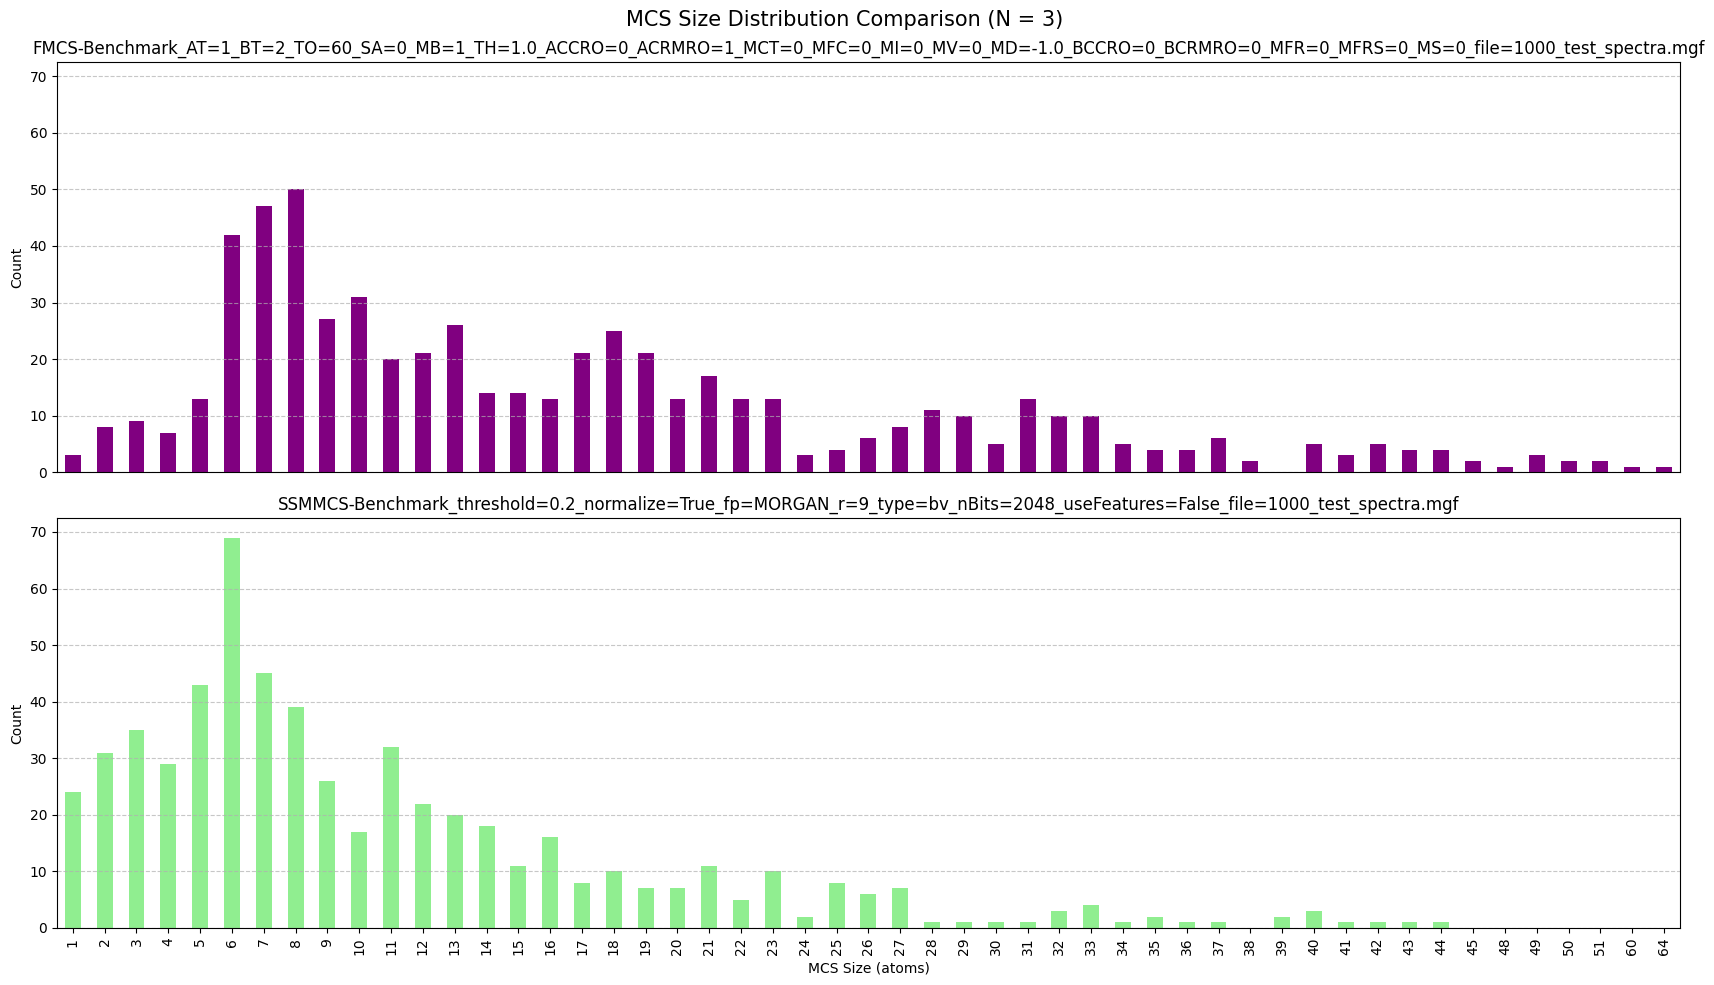

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Get all unique MCS sizes that appear in either dataframe
all_sizes = sorted(
    set(fmcs_df["mcs_size"].unique()) | set(ssmmcs_df[ssmmcs_df["mcs_size"] > 0]["mcs_size"].unique())
)

# Create Series with counts for each size, including zeros for missing values
fmcs_counts = (
    fmcs_df["mcs_size"].value_counts().reindex(all_sizes, fill_value=0).sort_index()
)
ssmmcs_counts = (
    ssmmcs_df["mcs_size"].value_counts().reindex(all_sizes, fill_value=0).sort_index()
)

# Calculate the maximum count value across both distributions
max_count = max(fmcs_counts.max(), ssmmcs_counts.max())

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(17, 10))
fig.suptitle(f"MCS Size Distribution Comparison (N = {cse_fmcs_params.n})", fontsize=15)

# Plot FMCS distribution with consistent x-axis
fmcs_counts.plot(
    kind="bar",
    ax=ax1,
    title=cse_fmcs_params.method_params.__str__(),
    color="purple",  # Set color for FMCS bars
)
ax1.set_ylim(0, max_count * 1.05)  # Add 5% padding
ax1.set_xticks([])
ax1.set_xlabel("")
ax1.set_ylabel("Count")
ax1.grid(axis="y", linestyle="--", alpha=0.7)  # Add y-axis grid lines

# Plot SSMMCS distribution with consistent x-axis
ssmmcs_counts.plot(
    kind="bar",
    ax=ax2,
    title=cse_ssmmcs_params.method_params.__str__(),
    color="lightgreen",  # Set color for SSMMCS bars
)
ax2.set_ylim(0, max_count * 1.05)  # Add 5% padding
ax2.set_xlabel("MCS Size (atoms)")
ax2.set_ylabel("Count")
ax2.grid(axis="y", linestyle="--", alpha=0.7)  # Add y-axis grid lines

plt.tight_layout()
plt.savefig(
    os.path.join(
        DATA_FOLDER,
        f"mcs_size_distribution_comparison_n={cse_fmcs_params.n}_ssmmcs_vs_fmcs.png",
    ),
    dpi=300,
)
plt.show()

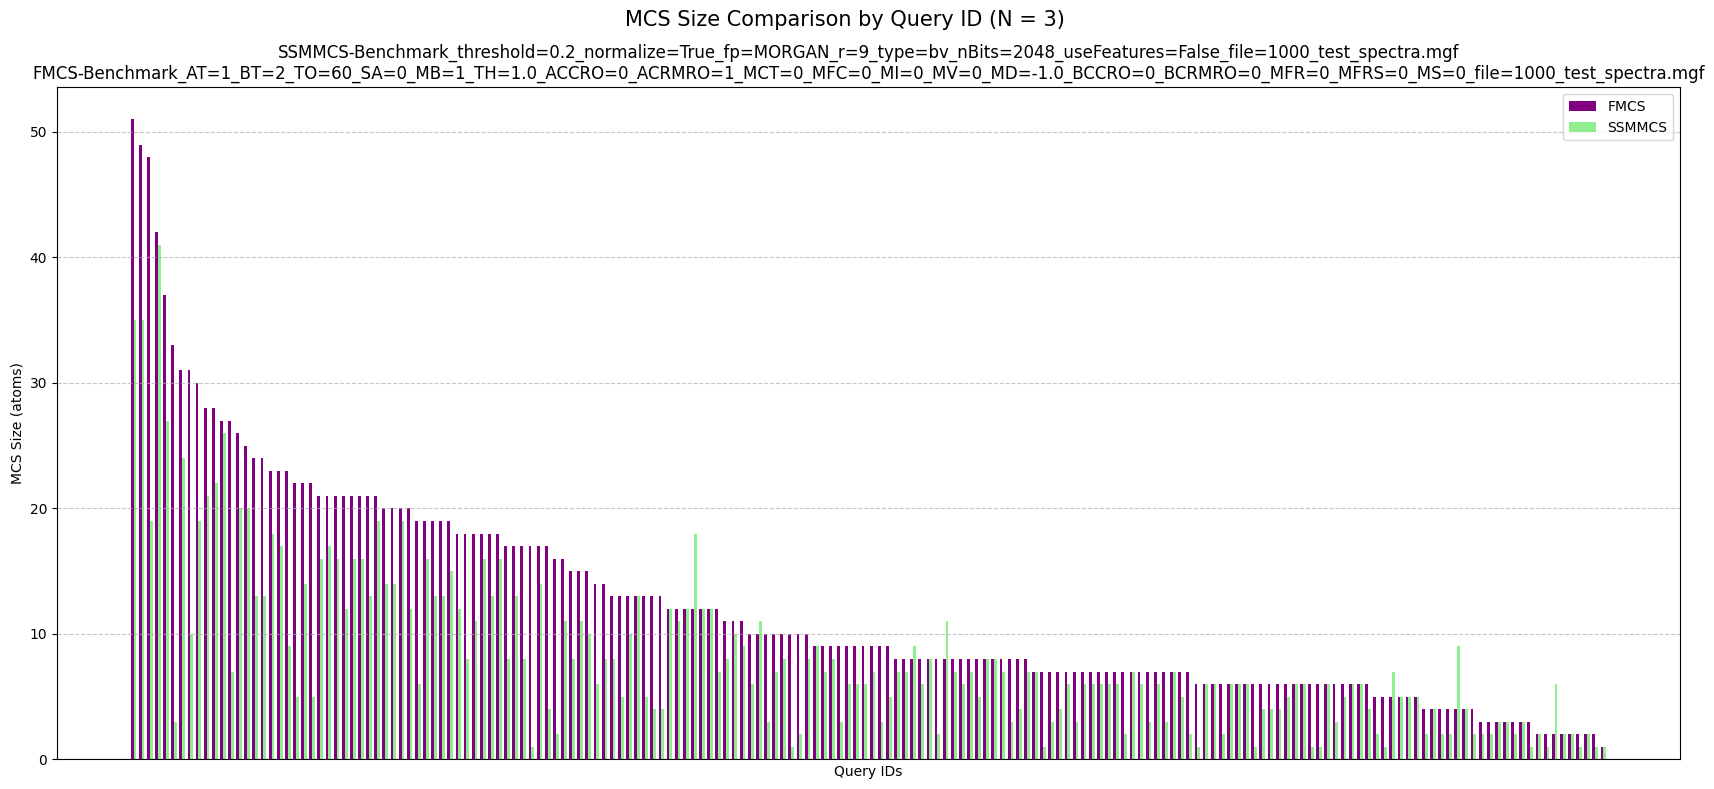

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# 1. First get all query IDs where both methods found a match
mask = (ssmmcs_df["mcs_matched_query"] == True) & (fmcs_df["mcs_matched_query"] == True)
matched_query_ids = fmcs_df[mask]["query_id"].unique()

# 2. Create a dataframe to hold the comparison data
comparison_df = pd.DataFrame({"query_id": [], "fmcs_size": [], "ssmmcs_size": []})

# 3. Populate the comparison dataframe
for qid in matched_query_ids:
    fmcs_size = fmcs_df[fmcs_df["query_id"] == qid]["mcs_size"].values[0]
    ssmmcs_size = ssmmcs_df[ssmmcs_df["query_id"] == qid]["mcs_size"].values[0]
    comparison_df = pd.concat(
        [
            comparison_df,
            pd.DataFrame(
                {
                    "query_id": [qid],
                    "fmcs_size": [fmcs_size],
                    "ssmmcs_size": [ssmmcs_size],
                    "difference": [ssmmcs_size - fmcs_size],
                }
            ),
        ],
        ignore_index=True,
    )

comparison_df = comparison_df.sort_values("fmcs_size", ascending=False)

# Setting up the bar chart with side-by-side bars
bar_width = 0.35
x = np.arange(len(comparison_df))

fig, ax = plt.subplots(figsize=(17, 8))

# Creating the bars
bar1 = ax.bar(
    x - bar_width / 2,
    comparison_df["fmcs_size"],
    bar_width,
    label="FMCS",
    color="purple",
)
bar2 = ax.bar(
    x + bar_width / 2,
    comparison_df["ssmmcs_size"],
    bar_width,
    label="SSMMCS",
    color="lightgreen",
)

# Add labels, title and legend
ax.set_xlabel("Query IDs")
ax.set_ylabel("MCS Size (atoms)")
fig.suptitle(f"MCS Size Comparison by Query ID (N = {cse_fmcs_params.n})", fontsize=15)
ax.set_title(f"{cse_ssmmcs_params.method_params.__str__()}\n{cse_fmcs_params.method_params.__str__()}")
ax.set_xticks([])
ax.grid(axis="y", linestyle="--", alpha=0.7)  # Add y-axis grid lines

ax.legend()

plt.tight_layout()
plt.savefig(
    os.path.join(
        DATA_FOLDER,
        f"mcs_size_comparison_by_query_id_n={cse_fmcs_params.n}_ssmmcs_vs_fmcs.png",
    ),
    dpi=300,
)
plt.show()

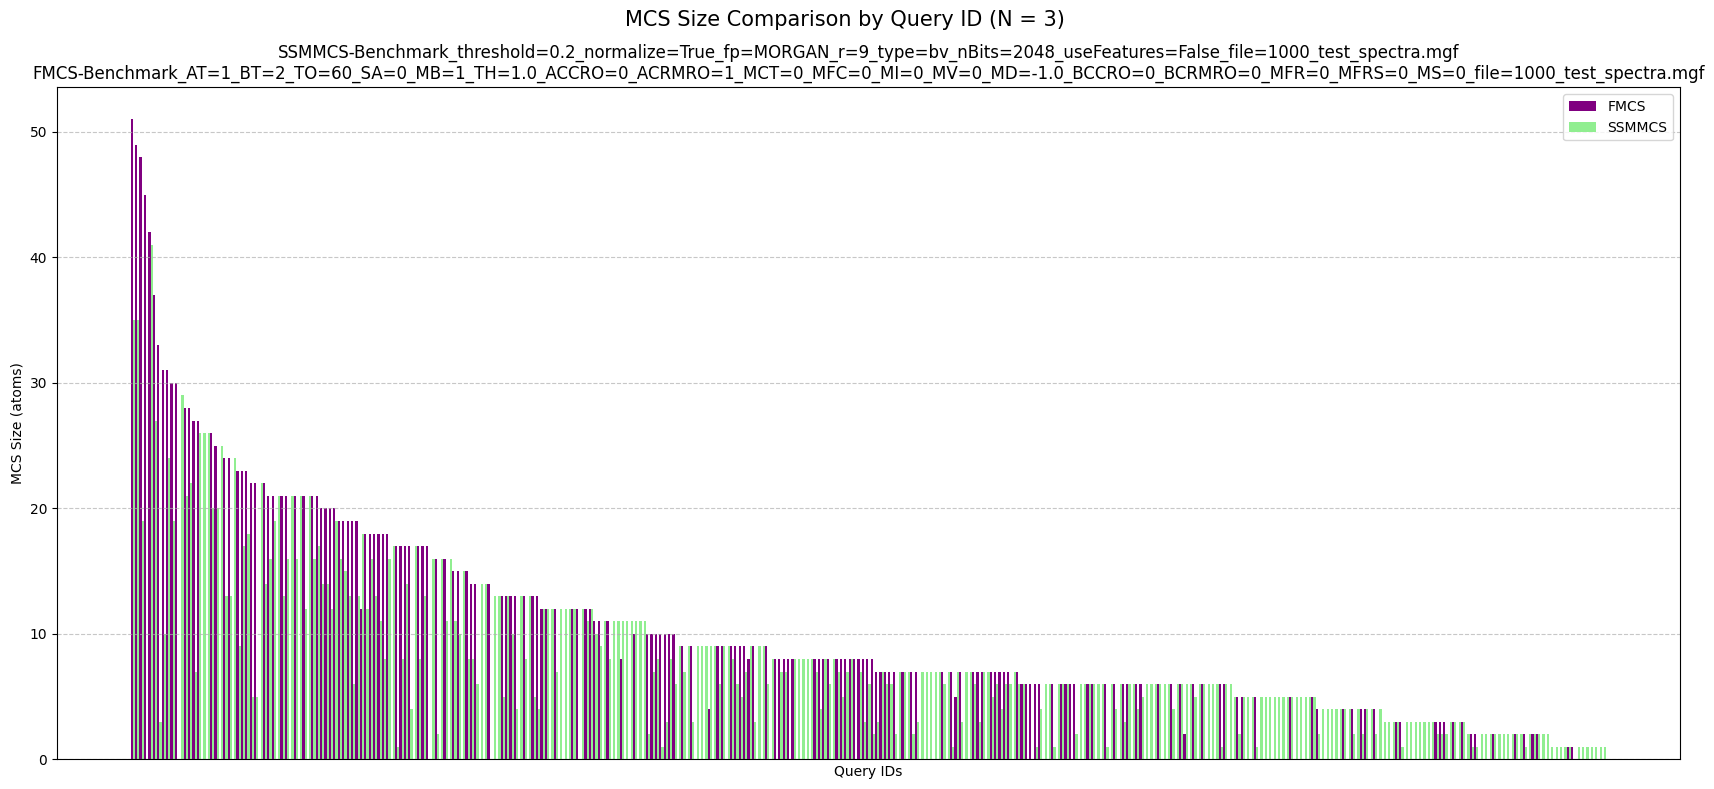

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Get all unique query IDs from both dataframes
all_query_ids = set(fmcs_df["query_id"]).union(set(ssmmcs_df["query_id"]))

# Create a dataframe to hold the comparison data
comparison_df = pd.DataFrame(columns=["query_id", "fmcs_size", "ssmmcs_size"])

# Populate the comparison dataframe for all query IDs
for qid in all_query_ids:
    # Get FMCS size if available
    fmcs_row = fmcs_df[fmcs_df["query_id"] == qid]
    fmcs_size = fmcs_row["mcs_size"].values[0] if len(fmcs_row) > 0 and fmcs_row["mcs_matched_query"].values[0] else 0
    
    # Get SSMMCS size if available
    ssmmcs_row = ssmmcs_df[ssmmcs_df["query_id"] == qid]
    ssmmcs_size = ssmmcs_row["mcs_size"].values[0] if len(ssmmcs_row) > 0 and ssmmcs_row["mcs_matched_query"].values[0] else 0
    
    # Add to dataframe only if at least one method found a match
    if fmcs_size > 0 or ssmmcs_size > 0:
        new_row = {
            "query_id": qid,
            "fmcs_size": fmcs_size,
            "ssmmcs_size": ssmmcs_size,
            "difference": ssmmcs_size - fmcs_size
        }
        comparison_df = pd.concat([comparison_df, pd.DataFrame([new_row])], ignore_index=True)

# Sort by maximum MCS size (either method) for better visualization
comparison_df["max_size"] = comparison_df[["fmcs_size", "ssmmcs_size"]].max(axis=1)
comparison_df = comparison_df.sort_values("max_size", ascending=False)

# Setting up the bar chart with side-by-side bars
bar_width = 0.5
x = np.arange(len(comparison_df))

fig, ax = plt.subplots(figsize=(17, 8))

# Creating the bars - only show bars for non-zero values
bar1 = ax.bar(
    x - bar_width / 2,
    comparison_df["fmcs_size"],
    bar_width,
    label="FMCS",
    color="purple",
)
bar2 = ax.bar(
    x + bar_width / 2,
    comparison_df["ssmmcs_size"],
    bar_width,
    label="SSMMCS",
    color="lightgreen",
)

# Add labels, title and legend
ax.set_xlabel("Query IDs")
ax.set_ylabel("MCS Size (atoms)")
fig.suptitle(f"MCS Size Comparison by Query ID (N = {cse_fmcs_params.n})", fontsize=15)
ax.set_title(f"{cse_ssmmcs_params.method_params.__str__()}\n{cse_fmcs_params.method_params.__str__()}")
ax.set_xticks([])
ax.grid(axis="y", linestyle="--", alpha=0.7)

ax.legend()

plt.tight_layout()
plt.savefig(
    os.path.join(
        DATA_FOLDER,
        f"mcs_size_comparison_by_query_id_(all_mcs)_n={cse_fmcs_params.n}_ssmmcs_vs_fmcs.png",
    ),
    dpi=300,
)
plt.show()

## Misc

In [36]:
benchmark_df = pd.DataFrame(
    columns=[
        "method",
        "matched_ratio",
        "avg_mcs_size",
        "computation_time",
        "matched_query_ids",
        "aborted_query_ids",
        "mcs_sizes",
        "mcs_matches",
    ]
)

csv_file = os.path.join(DATA_FOLDER, f"benchmark_results_for_{FILENAME} - n={N}.csv")
#benchmark_df.to_csv(csv_file, index=False)
print(f"Benchmark results saved to {csv_file}")

Benchmark results saved to data\benchmark_results_for_1000_test_spectra.mgf - n=3.csv


In [37]:
benchmark_df

,method,matched_ratio,avg_mcs_size,computation_time,matched_query_ids,aborted_query_ids,mcs_sizes,mcs_matches


In [38]:
import rdkit.Chem.Draw as Draw


query_id = 0

Draw.MolToImage(
    query_mols[query_id]
)  # , highlightAtoms=mcs_matches_FMCS[query_id], size=(300, 300))
fmcs = rdFMCS.FindMCS(get_query_analogues(query_id), fmcs_params.params)
fmcs_dict = fmcs.degenerateSmartsQueryMolDict

TypeError: get_query_analogues() missing 1 required positional argument: 'analogues_df'

In [ ]:
fmcs_params.params.StoreAll = False
benchmark_fmcs(query_mols[query_id : query_id + 1], fmcs_params)

Benchmarking FMCS:   0%|          | 0/1 [00:00<?, ?it/s]

,query_id,mcs_matched_query,failed,time,mcs_size,mcs_smarts,query_match,degenerate_smarts
0,0,True,False,0.004001,42,[#6&!R]-[#6&!R]-[#6&!R]-[#6&!R]-[#6&!R]-[#6&!R...,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",None


In [ ]:
# This causes the RuntimeError:
# FMCS. Invalid argument. mols.size() must be at least 2:
# maximum_common_substruct = rdFMCS.FindMCS(get_query_analogues(query_id), params)
# TODO: Why has this thing only 2 analogues? Also why do all the analogues only have 1 query id? Shouldn't some analogues have multiple? Query_ID should be Query_IDs and might be buggy.

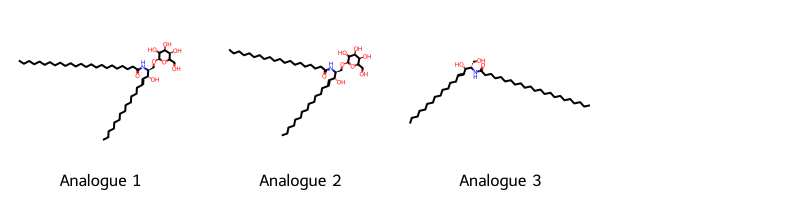

In [ ]:
Draw.MolsToGridImage(
    get_query_analogues(query_id),
    molsPerRow=4,
    legends=[f"Analogue {i+1}" for i in range(N)],
)